<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/LSTM_anomaly_demo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Init IDS data**

In [ ]:
#@title download data
!rm -rf /cic && git clone https://github.com/lifesboy/selks-lstm-data.git /cic

Cloning into '/cic'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 77 (delta 32), reused 20 (delta 0), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [ ]:
#@title import libs

from matplotlib import pyplot as plt
import go
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils

def show_scattered(x):
  A = np.matrix(x)
  #scatter plot x - column 0, y - column 1, shown with marker o
  plt.plot(A[:, 0], A[:, 1], 'o', label = 'data')
  plt.legend()
  plt.show()

In [ ]:
df = pd.read_csv('/cic/dataset/feature_extracted/cic2018/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv.00001.csv.00000.csv')
df.head(2)
df.drop(df.loc[df['label'] == 'label'].index, inplace=True)

In [ ]:
metadata = ['fl_dur' #Flow duration
,'tot_fw_pk' #Total packets in the forward direction
,'tot_bw_pk' #Total packets in the backward direction
,'tot_l_fw_pkt' #Total size of packet in forward direction
,'fw_pkt_l_max' #Maximum size of packet in forward direction
,'fw_pkt_l_min' #Minimum size of packet in forward direction
,'fw_pkt_l_avg' #Average size of packet in forward direction
,'fw_pkt_l_std' #Standard deviation size of packet in forward direction
,'Bw_pkt_l_max' #Maximum size of packet in backward direction
,'Bw_pkt_l_min' #Minimum size of packet in backward direction
,'Bw_pkt_l_avg' #Mean size of packet in backward direction
,'Bw_pkt_l_std' #Standard deviation size of packet in backward direction
,'fl_byt_s' #flow byte rate that is number of packets transferred per second
,'fl_pkt_s' #flow packets rate that is number of packets transferred per second
,'fl_iat_avg' #Average time between two flows
,'fl_iat_std' #Standard deviation time two flows
,'fl_iat_max' #Maximum time between two flows
,'fl_iat_min' #Minimum time between two flows
,'fw_iat_tot' #Total time between two packets sent in the forward direction
,'fw_iat_avg' #Mean time between two packets sent in the forward direction
,'fw_iat_std' #Standard deviation time between two packets sent in the forward direction
,'fw_iat_max' #Maximum time between two packets sent in the forward direction
,'fw_iat_min' #Minimum time between two packets sent in the forward direction
,'bw_iat_tot' #Total time between two packets sent in the backward direction
,'bw_iat_avg' #Mean time between two packets sent in the backward direction
,'bw_iat_std' #Standard deviation time between two packets sent in the backward direction
,'bw_iat_max' #Maximum time between two packets sent in the backward direction
,'bw_iat_min' #Minimum time between two packets sent in the backward direction
,'fw_psh_flag' #Number of times the PSH flag was set in packets travelling in the forward direction (0 for UDP)
,'bw_psh_flag' #Number of times the PSH flag was set in packets travelling in the backward direction (0 for UDP)
,'fw_urg_flag' #Number of times the URG flag was set in packets travelling in the forward direction (0 for UDP)
,'bw_urg_flag' #Number of times the URG flag was set in packets travelling in the backward direction (0 for UDP)
,'fw_hdr_len' #Total bytes used for headers in the forward direction
,'bw_hdr_len' #Total bytes used for headers in the forward direction
,'fw_pkt_s' #Number of forward packets per second
,'bw_pkt_s' #Number of backward packets per second
,'pkt_len_min' #Minimum length of a flow
,'pkt_len_max' #Maximum length of a flow
,'pkt_len_avg' #Mean length of a flow
,'pkt_len_std' #Standard deviation length of a flow
,'pkt_len_va' #Minimum inter-arrival time of packet
,'fin_cnt' #Number of packets with FIN
,'syn_cnt' #Number of packets with SYN
,'rst_cnt' #Number of packets with RST
,'pst_cnt' #Number of packets with PUSH
,'ack_cnt' #Number of packets with ACK
,'urg_cnt' #Number of packets with URG
,'cwe_cnt' #Number of packets with CWE
,'ece_cnt' #Number of packets with ECE
,'down_up_ratio' #Download and upload ratio
,'pkt_size_avg' #Average size of packet
,'fw_seg_avg' #Average size observed in the forward direction
,'bw_seg_avg' #Average size observed in the backward direction
,'fw_byt_blk_avg' #Average number of bytes bulk rate in the forward direction
,'fw_pkt_blk_avg' #Average number of packets bulk rate in the forward direction
,'fw_blk_rate_avg' #Average number of bulk rate in the forward direction
,'bw_byt_blk_avg' #Average number of bytes bulk rate in the backward direction
,'bw_pkt_blk_avg' #Average number of packets bulk rate in the backward direction
,'bw_blk_rate_avg' #Average number of bulk rate in the backward direction
,'subfl_fw_pk' #The average number of packets in a sub flow in the forward direction
,'subfl_fw_byt' #The average number of bytes in a sub flow in the forward direction
,'subfl_bw_pkt' #The average number of packets in a sub flow in the backward direction
,'subfl_bw_byt' #The average number of bytes in a sub flow in the backward direction
,'fw_win_byt' #Number of bytes sent in initial window in the forward direction
,'bw_win_byt' ## of bytes sent in initial window in the backward direction
,'Fw_act_pkt' ## of packets with at least 1 byte of TCP data payload in the forward direction
,'fw_seg_min' #Minimum segment size observed in the forward direction
,'atv_avg' #Mean time a flow was active before becoming idle
,'atv_std' #Standard deviation time a flow was active before becoming idle
,'atv_max' #Maximum time a flow was active before becoming idle
,'atv_min' #Minimum time a flow was active before becoming idle
,'idl_avg' #Mean time a flow was idle before becoming active
,'idl_std' #Standard deviation time a flow was idle before becoming active
,'idl_max' #Maximum time a flow was idle before becoming active
,'idl_min' #Minimum time a flow was idle before becoming active
]

In [ ]:
df.columns

Index(['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
      

## **LSTM**

### **Binary Class**

#### **Prepare data**

In [ ]:
features = ['Timestamp', 'Fwd Pkt Len Std', 'Fwd Pkt Len Mean',
       'Fwd Pkt Len Max', 'Fwd Seg Size Avg', 'Pkt Len Std', 'Flow IAT Std',
       'Bwd Pkt Len Std', 'Bwd Seg Size Avg', 'Pkt Size Avg',
       'Subflow Fwd Byts']
features = [i.lower().replace(' ', '_') for i in features]

In [ ]:
def targetify(s):
    if s == 'Benign':
        return 0
    else:
        return 1

In [ ]:
X = df[features]
X[features] = X[features].apply(pd.to_numeric, errors='coerce', axis=1)
X = X.fillna(0)
labels = df['label']    #For multiclass classification


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
df['target']=df['label'].apply(targetify)
y = df['target']

Normal Execution

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(80000, 11) (80000,)
(20000, 11) (20000,)


Faster Execution (1% rows)

In [ ]:
# selecting 1% of random rows for better running time

#X_train = X_train.sample(frac=0.1, replace=True, random_state=1)
#y_train = y_train.sample(frac=0.1, replace=True, random_state=1)
#X_test = X_test.sample(frac=0.1, replace=True, random_state=1)
#y_test = y_test.sample(frac=0.1, replace=True, random_state=1)
#print (X_train.shape, y_train.shape)
#print( X_test.shape, y_test.shape)

(8000, 11) (8000,)
(2000, 11) (2000,)


#### **Train**

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(x_scaled,columns=features)
x_scaled_test = min_max_scaler.fit_transform(X_test.values)
X_test = pd.DataFrame(x_scaled_test,columns=features)

train_size = 1000
test_size = 200
n_timestamp_in = 30
n_features = 11

CX_train = X_train.sample(train_size * n_timestamp_in).values.reshape(train_size, n_timestamp_in, n_features)
Cy_train = y_train.sample(train_size * n_timestamp_in).values.reshape(train_size, n_timestamp_in, 1)

CX_test = X_test.sample(test_size * n_timestamp_in).values.reshape(test_size, n_timestamp_in, n_features)
Cy_test = y_train.sample(test_size * n_timestamp_in).values.reshape(test_size, n_timestamp_in, 1)

print("CX_train=", CX_train.shape)
print("Cy_train=", Cy_train.shape)
print("CX_test=", CX_test.shape)
print("Cy_test=", Cy_test.shape)


CX_train= (1000, 30, 11)
Cy_train= (1000, 30, 1)
CX_test= (200, 30, 11)
Cy_test= (200, 30, 1)


In [ ]:
cell_size = 128

model = Sequential()
model.add(tf.keras.layers.LSTM(cell_size, input_shape=(n_timestamp_in, n_features)))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.RepeatVector(n_timestamp_in))
model.add(tf.keras.layers.LSTM(cell_size, return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               71680     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_8 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [ ]:
#Bidirection LSTM
model.compile(optimizer='adam', loss='mae')

history = model.fit(CX_train, Cy_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/100
29/29 [==============================] - 8s 135ms/step - loss: 0.4238 - val_loss: 0.1848
Epoch 2/100
29/29 [==============================] - 3s 100ms/step - loss: 0.1287 - val_loss: 0.0682
Epoch 3/100
29/29 [==============================] - 3s 102ms/step - loss: 0.0919 - val_loss: 0.0501
Epoch 4/100
29/29 [==============================] - 3s 100ms/step - loss: 0.0749 - val_loss: 0.0465
Epoch 5/100
29/29 [==============================] - 3s 101ms/step - loss: 0.0634 - val_loss: 0.0677
Epoch 6/100
29/29 [==============================] - 3s 121ms/step - loss: 0.0596 - val_loss: 0.0344
Epoch 7/100
29/29 [==============================] - 5s 157ms/step - loss: 0.0481 - val_loss: 0.0323
Epoch 8/100
29/29 [==============================] - 3s 101ms/step - loss: 0.0427 - val_loss: 0.0225
Epoch 9/100
29/29 [==============================] - 3s 98ms/step - loss: 0.0416 - val_loss: 0.0148
Epoch 10/100
29/29 [==============================] - 3s 100ms/step - loss: 0.0388 - val_los

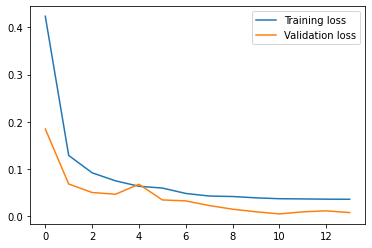

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

#### **Infer**

##### Train data

7/7 [==============================] - 0s 29ms/step - loss: 0.0069
Reconstruction error threshold: 1.0065378626187642


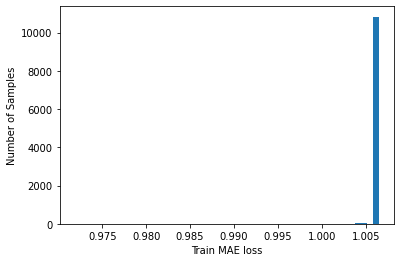

In [ ]:
model.evaluate(CX_test, Cy_test)

CX_train_pred = model.predict(CX_train, verbose=0)
train_mae_loss = np.mean(np.abs(CX_train_pred - CX_train), axis=1).reshape([-1])

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

#show_scattered(Cy_train)
#show_scattered(CX_train_pred)

##### Test data

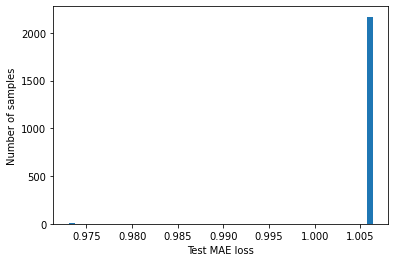

In [ ]:
CX_test_pred = model.predict(CX_test, verbose=0)
test_mae_loss = np.mean(np.abs(CX_test_pred - CX_test), axis=1).reshape([-1])
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
print("CX_test=", CX_test.shape)
print("Cy_test=", Cy_test.shape)
test_score_df = pd.DataFrame(Cy_test.reshape([-1]))

#test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold



import plotly.express as px
df = px.data.medals_long()

fig = px.scatter(df, y=test_score_df[0], x=test_score_df[1])
fig.show()

CX_test= (200, 30, 11)
Cy_test= (200, 30, 1)


KeyError: ignored

### **Multi Class**

In [ ]:
categories = ['Benign', 'FTP-BruteForce', 'SSH-Bruteforce',
              'DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'DoS attacks-SlowHTTPTest',
              'DoS attacks-Hulk', 'Brute Force -Web', 'Brute Force -XSS',
              'SQL Injection', 'Infiltration', 'Bot']

In [ ]:
encoder = LabelEncoder()
encoder.fit(categories)
y = encoder.transform(labels)
y = np_utils.to_categorical(y, num_classes=12)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(100000, 64, embeddings_regularizer='l2'), # since it doesn't consider "words," the embedding doesn't really matter
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu', use_bias=True, bias_regularizer='l2'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(12, activation='sigmoid')
    # tf.keras.layers.Dense(1, activation='softmax') # loss too big
])

In [ ]:
X_train.shape, y_train.shape

((8000, 11), (8000,))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              # optimizer='sgd', # almost same
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
history = model.fit(X_train.values, y_train.values, epochs=3)
model.save('/cic/models/LSTM_MC_L2')

Epoch 1/3
250/250 [==============================] - 20s 66ms/step - loss: 27.7375 - accuracy: 0.9542
Epoch 2/3
250/250 [==============================] - 17s 69ms/step - loss: 4.7209 - accuracy: 0.9992
Epoch 3/3
250/250 [==============================] - 17s 67ms/step - loss: 0.5917 - accuracy: 0.9992


63/63 [==============================] - 0s 4ms/step


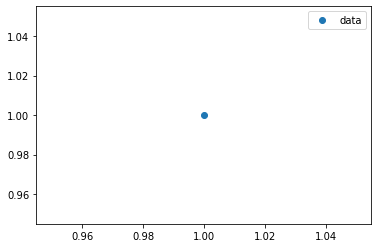

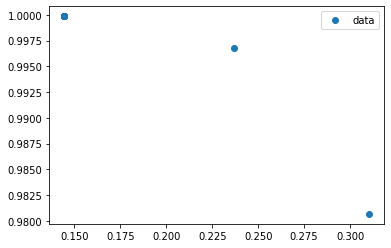

In [ ]:
pred_class = model.predict(X_test.values[:])
predictions = [int(round(x[0])) for x in pred_class]
true_class = list(y_test)
np.sum(predictions == y_test.values) / len(y_test.values)

show_scattered(y_test.values)
show_scattered(pred_class)

In [ ]:
compdf = pd.DataFrame({'pred_class':predictions, 'true_class':true_class})
compdf = compdf.sort_values('pred_class', ascending=True)
predictions = list(compdf['pred_class'].apply(myRound, r=225))
true_class = list(compdf['true_class'])

In [ ]:
confm = confusion_matrix(true_class, predictions)
confm

array([[   4,    0],
       [1996,    0]])

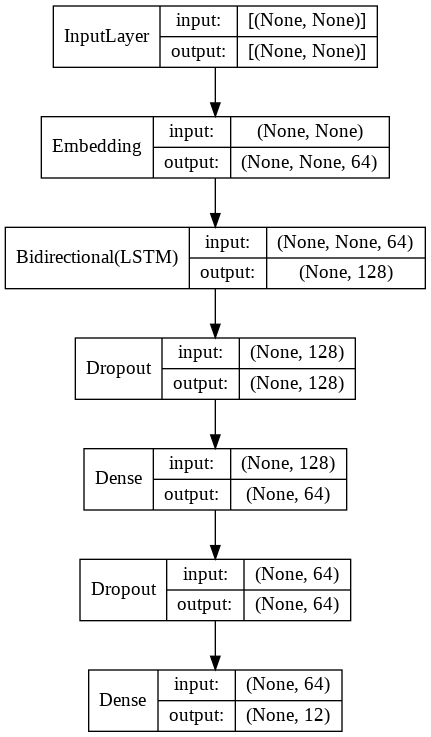

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)